# The Weekend Effect: Short Term Trading Backtest

Investors believe there exists a "weekend effect" which stipulates that a declining market on a Friday is followed by a decline on Monday. To test this hypothesis I download historical SPX prices from the Wall Street Journal website:

https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

The script investigates the return profile of selling short SPX on Mondays preceeded by significant selloffs on the previous Friday.

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (15,5)

Dataset includes all days from 01-01-2000 until today. Hence, I filtered out all weekdays except for Fridays and Mondays. After filtering, the dataset needs to be adjusted for missing pairs such as single Fridays (e.x. there are often holidays on Mondays and markets are closed). Finally, returns are multiplied by 100 to transform to percentage numbers from decimals.



In [2]:
ret_data = pd.read_csv("HistoricalPrices_prepped.csv",
                       parse_dates = ["Date"]).dropna()

ret_data = ret_data.iloc[::-1]
print(ret_data.dtypes)
ret_data.set_index(["Date"], inplace = True)
ret_data.tail()

Date       datetime64[ns]
Returns           float64
Weekday           float64
dtype: object


,Returns,Weekday
Date,,
2020-01-13,0.6952,2.0
2020-01-24,-0.9083,6.0
2020-01-27,-1.5856,2.0
2020-01-31,-1.7864,6.0
2020-02-03,0.7228,2.0


### Plot and distribution of Friday & Monday returns

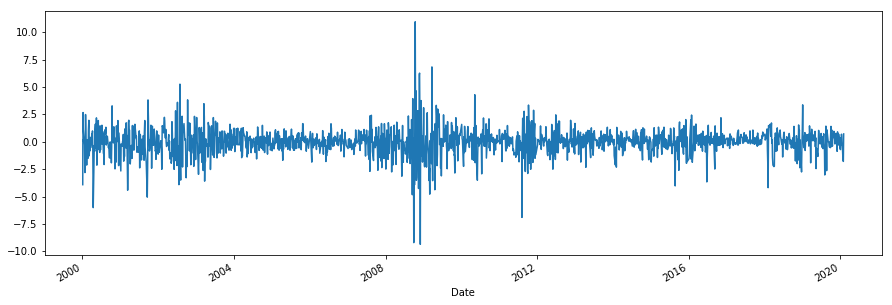

In [3]:
ret_data.Returns.plot(figsize = (15,5))

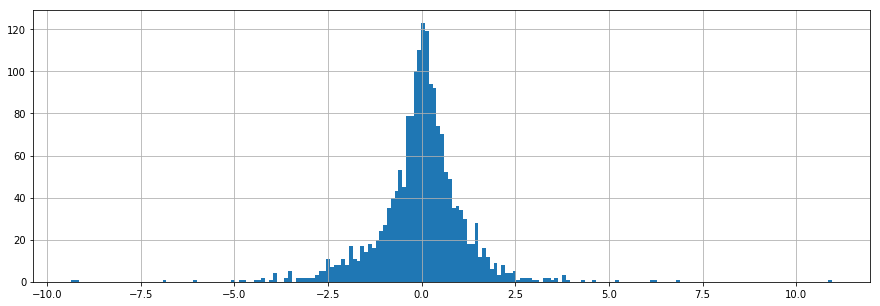

In [4]:
ret_data.Returns.hist(bins = 200, figsize = (15,5))

In [5]:
ret_data.Returns.describe()

count    1835.000000
mean       -0.023898
std         1.204175
min        -9.353700
25%        -0.481150
50%         0.037800
75%         0.521600
max        10.957200
Name: Returns, dtype: float64

In [6]:
max_ind = np.where(ret_data.Returns == ret_data.Returns.max())
ret_data.index[max_ind][0]

Timestamp('2008-10-13 00:00:00')

In [7]:
min_ind = np.where(ret_data.Returns == ret_data.Returns.min())
ret_data.index[min_ind][0]

Timestamp('2008-12-01 00:00:00')

In [8]:
ret_data.Returns.median()

0.0378

The plot of the returns shows increased volatility during the early 2000s and then post 2008 as expected. The distribution of Friday/Monday returns shows a symmetric distribution around 0% but there appears to be fairly high kurtosis as well as fat tails suggesting that the returns are not normally distributed. In fact, we have returns of +- 10% on certain Monday/Friday pairs. 

Let's investigate if there is any autocorrelation.

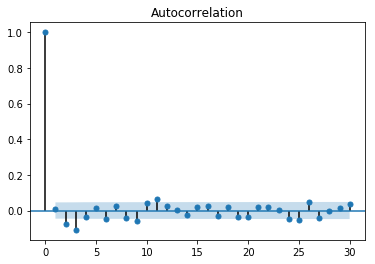

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ret_data.Returns, lags=30)
plt.show()

In [10]:
mondays = ret_data.loc[ret_data.Weekday == 2]
fridays = ret_data.loc[ret_data.Weekday == 6]

In [11]:
np.corrcoef(fridays.Returns, mondays.Returns)

array([[1.        , 0.06536109],
       [0.06536109, 1.        ]])

Text(0, 0.5, 'Monday Returns %')

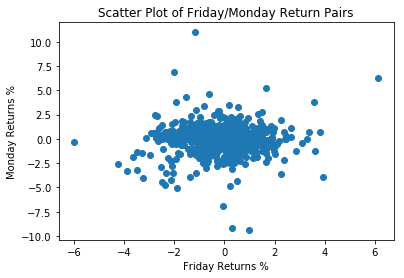

In [12]:
plt.scatter(x = fridays.Returns,y= mondays.Returns)
plt.title("Scatter Plot of Friday/Monday Return Pairs")
plt.xlabel("Friday Returns %")
plt.ylabel("Monday Returns %")

There appears to be no correlation between the returns from Friday into Monday. The ACF plot shows negative autocorrelation from a lag of 2 and three but this runs contrary to our hypothesis which only focuses on single lag correlation (i.e. Friday to Monday only). The scatter plot also shows a horizontal scatter meaning no relationship in returns and hence no "weekend effect."

### Strategy Backtest

The logic of this strategy is to short (long) the SPX on a Monday if the returns on the preceeding Friday were below (above) a certain threshold.

Sharpe: 0.06639133322373154
Avg. Return: 0.13478359375
Median. Return: -0.05935
Min. Return: -10.9572
Max. Return: 5.0468
Win Rate: 0.453125
Number of Trades: 128
Any Fridays included: False


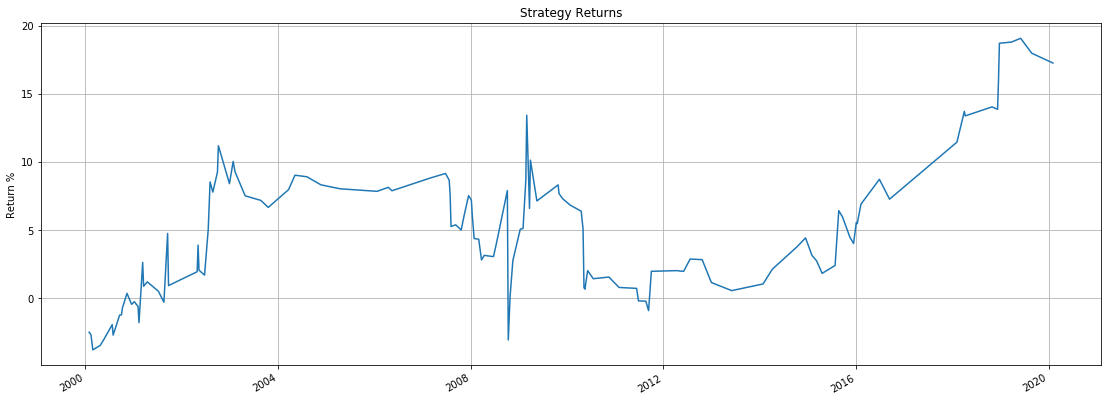

In [13]:
# dataframe to hold series of Monday returns
pnl = pd.DataFrame()

# loop through the returns dataset
for i in range(1,ret_data.shape[0]):
    ystr = ret_data.iloc[i-1].copy() # previous day
    today = ret_data.iloc[i].copy()  # trading day

    # check if previous day was Friday
    # check if returns are above (below) threshold
    # if both check out, append return to pnl vector
    if ystr.Weekday == 6 and ystr.Returns < -1.0:
        today.Returns = -today.Returns # negative for short side
        pnl = pnl.append(today)
    
#    # add the long side of the trade 
#    elif ystr.Weekday == 6 and ystr.Returns > 1.0:
#        pnl = pnl.append(today)

pnl.Returns.cumsum().plot(figsize = (19,7))
plt.title("Strategy Returns")
plt.ylabel("Return %")
plt.grid()

print("Sharpe:",pnl.Returns.mean()/pnl.Returns.std())
print("Avg. Return:",pnl.Returns.mean())
print("Median. Return:",pnl.Returns.median())
print("Min. Return:",pnl.Returns.min())
print("Max. Return:",pnl.Returns.max())
print("Win Rate:",np.mean(pnl.Returns > 0))
print("Number of Trades:",len(pnl.Returns))
print("Any Fridays included:", np.any(pnl.Weekday == 6))

The return profile does not suggest that there is any real alpha in this strategy. In fact, changing thresholds achieves a 0.5 Sharpe ratio at best and even on this best case scenario (with overfitting) it does not match the return of simply holding the SPX over this period. 

In [14]:
pnl

,Returns,Weekday
2000-01-31,-2.4905,2.0
2000-02-14,-0.2031,2.0
2000-02-28,-1.0957,2.0
2000-04-24,0.3268,2.0
2000-05-22,0.4438,2.0
2000-07-24,1.0800,2.0
2000-07-31,-0.7675,2.0
2000-09-18,1.4638,2.0
2000-10-02,0.0195,2.0
2000-10-09,0.4952,2.0
